In [27]:
import pandas as pd
import helper_functions as h
from nltk import sent_tokenize
from sklearn.model_selection import LeaveOneGroupOut
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

Thoughts on setting up for leave one out approach:
- Should be similar to custom split, except instead of randomly assigning all the ids to a group based on a percentage a single id will be chosen for test and the rest put into train; to iterate correctly the test id needs to be put back into train for the following runs.
- list with unique text ids

If using sci-kit learn's LeaveOneGroupOut, the group would be the text id, so it should work the way I want without custom coding it?

I actually think I'll understand what's going on much better if I code it. The examples using the out-of-the-box function aren't a great fit for what I want to do (and the way my data is structured) and are complicated anyway.

In [2]:
metadata = pd.read_csv('../data/metadata.csv')

In [3]:
metadata.head()

,text#,title,author,words,text_length,is_Austen,is_Austen_bool
0,55697983,We Have Been Trying To Reach You About Your Li...,Katri,11116,short,Not Austen,0
1,55785940,The Younger Son,Sonetka,7164,short,Not Austen,0
2,55435072,Golden,Courtney621,12066,short,Not Austen,0
3,55189105,The Settlement of Lady Elliot's Piano,Gwynterys,5941,short,Not Austen,0
4,53512534,A Different Bennet Family,Fanfictionfan_01_1981,34346,medium,Not Austen,0


In [8]:
# subset to texts over 60K words
metadata = metadata[metadata['text_length'] == 'long'].copy()

In [10]:
id_list = metadata['text#']
df_list = [] # df from each loop appended to list

for id in id_list:
    text = h.read_text(id)      # read in text
    sent_text = sent_tokenize(text)     # tokenize text by sentence
    token_text, token_num, token_char_count, token_sent_count, token_word_count = h.get_tokens(sent_text)    # split text into tokens with sentence structure in mind
    df = pd.DataFrame(list(zip(token_text, token_num, token_char_count, token_sent_count, token_word_count)), 
                            columns = ['token_text', 'token_num', 'token_char_count', 'token_sent_count', 'token_word_count'])
    df['text#'] = id
    df_list.append(df)    # list of dataframes with token data

token_df = pd.concat(df_list)

token_2000 = pd.merge(metadata, token_df, on = 'text#')

In [11]:
# all but one id in train_ids, remaining in test_ids
ids = token_2000['text#'].unique().tolist()

for id in ids:
    train_ids = list(filter(lambda x: x != id, ids))
    test_ids = [[id]]

In [12]:
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3
 
# Driver Code
print(intersection(train_ids, test_ids))
# confirmation it works the way I expect

[]


In [14]:
token_2000['text#'].nunique()
# 46 book-length texts including 6 Austen novels and 40 fanfic works

46

Model will be built and trained inside the loop.

In my mind I want to end up with validation metrics appended to the dataframe so I can see how it changes by novel and also perhaps by position in the text (since the tokens are numbered sequentially). To do that, in each iteration I have a test dataset for which predictions are being made. The prediction (proba) series can be joined to the test dataframe since they should be in the same order. Include the token_num as a column since that is a unique identifier within each text? This seems similar to how we joined the predictions onto the test data to submit for the Kaggle project.

Each test dataframe should be appended to a list of dataframes and all of them concatenated together once all the iterations are done. This should result in a dataframe the same length as the original but with additional validation information.

To validate: if I save the prediction as a df column, I should be able to use it to calculate other evaluation metrics I think?

Start with the previously used vectorizer model. Instead of the custom train-test split, use leave one out. For each id, generate predictions and append the predictions to the appropriate subset of the full dataframe. Add the subset dataframe to a list. At the end of the iterations concat the df into one.

In [15]:
# list to iterate over
ids = token_2000['text#'].unique().tolist()

logo_list = []
item_count = 0

for id in ids:
    train_ids = list(filter(lambda x: x != id, ids))
    test_ids = [id]

    # subset dataframe for test id
    id_tokens = token_2000[token_2000['text#'] == id].copy()

    # train-test-split
    X_train = token_2000[token_2000['text#'].isin(train_ids)]['token_text']
    X_test = token_2000[token_2000['text#'].isin(test_ids)]['token_text']
    y_train = token_2000[token_2000['text#'].isin(train_ids)]['is_Austen_bool']
    y_test = token_2000[token_2000['text#'].isin(test_ids)]['is_Austen_bool']

    vect = CountVectorizer()

    X_train_vec = vect.fit_transform(X_train)
    X_test_vec = vect.transform(X_test)

    nb = MultinomialNB().fit(X_train_vec, y_train)

    y_pred = nb.predict(X_test_vec)
    y_proba = nb.predict_proba(X_test_vec)

    id_tokens['predictions'] = y_pred
    id_tokens['probabilities'] = y_proba[:,1]

    logo_list.append(id_tokens)
    item_count += 1
    print(f'text id: {id}, loop: {item_count}')

logo_df = pd.concat(logo_list)

text id: 52705351, loop: 1
text id: 30672131, loop: 2
text id: 40263168, loop: 3
text id: 33964492, loop: 4
text id: 35534191, loop: 5
text id: 37522585, loop: 6
text id: 34200601, loop: 7
text id: 30497346, loop: 8
text id: 33704434, loop: 9
text id: 34889029, loop: 10
text id: 27536020, loop: 11
text id: 9401669, loop: 12
text id: 25053859, loop: 13
text id: 20325682, loop: 14
text id: 16334435, loop: 15
text id: 27446335, loop: 16
text id: 28268808, loop: 17
text id: 9680840, loop: 18
text id: 24216613, loop: 19
text id: 4102567, loop: 20
text id: 5762899, loop: 21
text id: 25706614, loop: 22
text id: 24009643, loop: 23
text id: 23907943, loop: 24
text id: 22911136, loop: 25
text id: 23294782, loop: 26
text id: 21285821, loop: 27
text id: 9832895, loop: 28
text id: 20520542, loop: 29
text id: 13708740, loop: 30
text id: 11344053, loop: 31
text id: 10896180, loop: 32
text id: 7013194, loop: 33
text id: 6770071, loop: 34
text id: 1805647, loop: 35
text id: 444476, loop: 36
text id: 20

Running this on all 350 texts took 18 minutes. For the sake of getting things done, narrow the dataset to novel-length texts (already have them classified, subset for 'long').

Took 1 minute to run with 46 texts, much more doable for this project.

In [16]:
logo_df.head()

,text#,title,author,words,text_length,is_Austen,is_Austen_bool,token_text,token_num,token_char_count,token_sent_count,token_word_count,predictions,probabilities
0,52705351,The Meek Shall Inherit,AvonleaBrigadoon,67407,long,Not Austen,0,21 July 1809 I am sixteen today: an age at whi...,1,1994,29,381,0,3.917950e-32
1,52705351,The Meek Shall Inherit,AvonleaBrigadoon,67407,long,Not Austen,0,24 July I have conquered the first phrase with...,2,1989,23,378,0,5.510400e-36
2,52705351,The Meek Shall Inherit,AvonleaBrigadoon,67407,long,Not Austen,0,"Jane and Lizzy tried speaking to Papa, saying ...",3,1966,23,384,0,1.999711e-29
3,52705351,The Meek Shall Inherit,AvonleaBrigadoon,67407,long,Not Austen,0,"I was so embarrassed, that I was not able to a...",4,1929,23,347,0,2.665862e-38
4,52705351,The Meek Shall Inherit,AvonleaBrigadoon,67407,long,Not Austen,0,"~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 28 December, 18...",5,1992,25,364,0,1.465096e-36


New columns from model:
- predictions 0 is not Austen, 1 is Austen
- probabilities is probability it is Austen so very low number is equivalent to very high probability of not Austen

Trying out some visualizations and overall metrics

These are overall metrics, but an interesting interactive visualization would be to have the ability to choose a text and have the visuals display specifically for that text.

[[10347   655]
 [  347  1793]]


<Axes: >

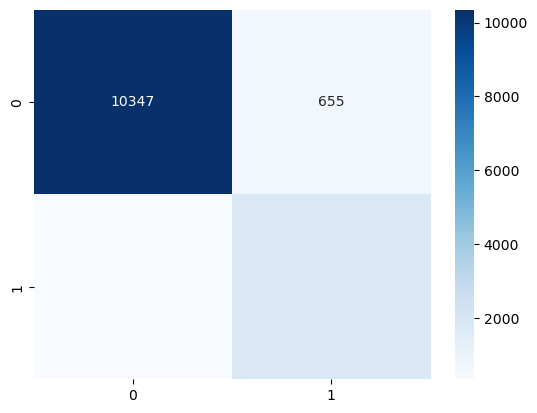

In [20]:
# create confusion matrix and generate heatmap

actual_val = logo_df['is_Austen_bool']
pred_val = logo_df['predictions']
conf_matrix = confusion_matrix(actual_val, pred_val)

print(conf_matrix)

sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = 'Blues');

# this does show the confusion matrix in a nicer way, but there's such an imbalance between the classes that the true positives (ie actually is Austen) still looks pretty minimal

In [23]:
# accuracy score
acc_score = accuracy_score(actual_val, pred_val)

acc_score

0.9237558971237254

In [26]:
# classification report
class_report = classification_report(actual_val, pred_val)

print(class_report)

              precision    recall  f1-score   support

           0       0.97      0.94      0.95     11002
           1       0.73      0.84      0.78      2140

    accuracy                           0.92     13142
   macro avg       0.85      0.89      0.87     13142
weighted avg       0.93      0.92      0.93     13142



In [ ]:
# bar chart showing percent of correct predictions per text

# new column to indicate correct prediction

# group by text and normalize

# chart

There seems to be greater variability among the Austen books leading to less accurate predictions - why is that? Determine which books have the most passages misclassified; try to see what the mis-classified passages might have in common and what makes them different from others. Are there particular fanfiction works that most successfully imitated Austen?